In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
data_true = pd.read_csv('/content/drive/MyDrive/True.csv')
data_fake = pd.read_csv('/content/drive/MyDrive/Fake.csv');

In [ ]:
data_fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [ ]:
value_counts = data_fake['subject'].value_counts()
print(value_counts)

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64


In [ ]:
print(data_true.isna().sum(), "\n")
print(data_fake.isna().sum())

title      0
text       0
subject    0
date       0
dtype: int64 

title      0
text       0
subject    0
date       0
dtype: int64


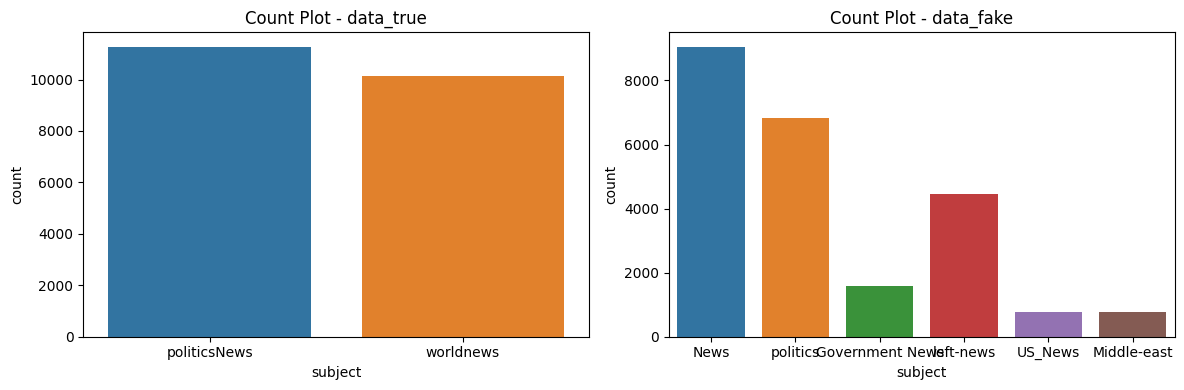

In [ ]:
plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(gs[0])
sns.countplot(x="subject", data=data_true, ax=ax1)
ax1.set_title("Count Plot - data_true")

ax2 = plt.subplot(gs[1])
sns.countplot(x="subject", data=data_fake, ax=ax2)
ax2.set_title("Count Plot - data_fake")

plt.tight_layout()

plt.show()

## Removing Publisher name from Real Data

In [ ]:
tmp_text = []
for index,row in enumerate(data_true.text.values):
    record = row.split(" -", maxsplit=1)
    if len(record) > 1:
      tmp_text.append(record[1])
    else:
      tmp_text.append(record[0])

In [ ]:
print(len(tmp_text))

21417


In [ ]:
data_true['text'] = tmp_text

In [ ]:
[index for index,text in enumerate(data_true.text.values) if str(text).strip() == '']

[8970]

In [ ]:
data_true = data_true.drop(8970, axis=0)

In [ ]:
empty_fake_index = [index for index,text in enumerate(data_fake.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
data_fake.iloc[empty_fake_index].tail()

No of empty rows: 630


,title,text,subject,date
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015"


In [ ]:
data_fake = data_fake.drop(empty_fake_index)

In [ ]:
data_fake.shape

(22851, 4)

In [ ]:
data_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
data_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017"


In [ ]:
data_true['label'] = 1;
data_fake['label'] = 0;


In [ ]:
data_true["text"] = data_true["title"] + " " + data_true["text"]
data_fake["text"] = data_fake["title"] + " " + data_fake["text"]

In [ ]:
data_true = data_true.drop(["subject", "date", "title"], axis=1)
data_fake = data_fake.drop(["subject", "date", "title"], axis=1)

In [ ]:
data = data_true.append(data_fake, ignore_index=True)

In [ ]:
data.shape

(44267, 2)

In [ ]:
y = data["label"].values
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

In [ ]:
import gensim

EMBEDDING_DIM = 100


w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=EMBEDDING_DIM, window=5, min_count=1)


In [ ]:
w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])

[('bush', 0.5419083833694458),
 ('cruz', 0.53872150182724),
 ('elect', 0.5234811902046204),
 ('hillary', 0.5109664797782898),
 ('incoming', 0.48525872826576233),
 ('sanders', 0.4746978282928467),
 ('course', 0.4697614908218384),
 ('bartlet', 0.46313244104385376),
 ('crooked', 0.4483843743801117),
 ('forcefulness', 0.43817660212516785)]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

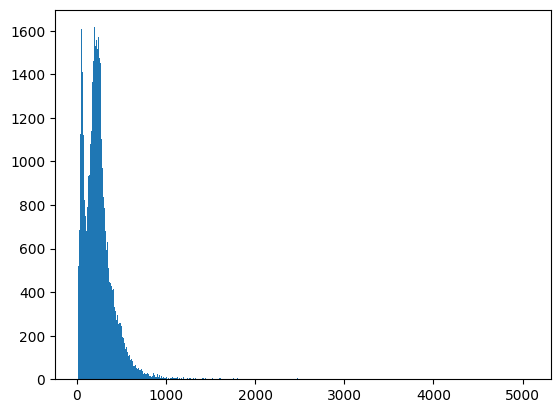

In [ ]:
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])

43353

In [ ]:
maxlen = 700

X = pad_sequences(X, maxlen=maxlen)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        if word in model.wv:
            weight_matrix[i] = model.wv[word]
    return weight_matrix


In [ ]:
word_index = tokenizer.word_index
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [ ]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          12223800  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 12341177 (47.08 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 12223800 (46.63 MB)
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
727/727 [==============================] - 28s 28ms/step - loss: 0.1269 - acc: 0.9546 - val_loss: 0.1048 - val_acc: 0.9659
Epoch 2/6
727/727 [==============================] - 20s 27ms/step - loss: 0.0650 - acc: 0.9778 - val_loss: 0.0470 - val_acc: 0.9834
Epoch 3/6
727/727 [==============================] - 22s 30ms/step - loss: 0.0399 - acc: 0.9861 - val_loss: 0.0470 - val_acc: 0.9821
Epoch 4/6
727/727 [==============================] - 22s 30ms/step - loss: 0.0281 - acc: 0.9904 - val_loss: 0.0359 - val_acc: 0.9870
Epoch 5/6
727/727 [==============================] - 23s 31ms/step - loss: 0.0245 - acc: 0.9920 - val_loss: 0.0262 - val_acc: 0.9914
Epoch 6/6
727/727 [==============================] - 20s 27ms/step - loss: 0.0182 - acc: 0.9936 - val_loss: 0.0237 - val_acc: 0.9919


In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

346/346 [==============================] - 7s 16ms/step


In [ ]:
accuracy_score(y_test, y_pred)

0.9912352037589229

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5669
           1       0.99      0.99      0.99      5398

    accuracy                           0.99     11067
   macro avg       0.99      0.99      0.99     11067
weighted avg       0.99      0.99      0.99     11067



In [ ]:
data_fake['text'][0]

' Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this 